#**MLP Model for credit card fraud detection**

#**Import Libraries**

In [ ]:
#install weight and biases for visulaization
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
#Import Packages
import wandb
import numpy as np
import torch
import torch.nn as nn #Base class for neural networks
import pandas as pd #For Preprocessing
from sklearn.preprocessing import StandardScaler #To standarize the data
from torch.utils.data import Dataset, DataLoader #Data set creation for training


In [ ]:
#setting wandb configerations
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#Define Configs
wandb.init(
    project ='Credit card fraud detection',
    config={
        "epochs":50,
        "batch_size": 32,
        "lr": 0.01
    }
)
config = wandb.config

wandb: Currently logged in as: nethmapeiris. Use `wandb login --relogin` to force relogin


**Link Kaggle data set to colab**

In [ ]:
#Link Kaggle data set to colab
!pip install -q kaggle

In [ ]:
#uplaod json file
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nethmapeiris","key":"5c99f08085706f90dd0c448650cceba7"}'}

In [ ]:
#create directory called kaggle and copy the json file
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
#change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 82% 54.0M/66.0M [00:00<00:00, 128MB/s]
100% 66.0M/66.0M [00:00<00:00, 127MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('creditcardfraud.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# EDA

In [ ]:
#import data
data = pd.read_csv('/content/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#since there are 31 columns the columns names will be displayed as bellow
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [ ]:
data=data.iloc[:-7]

In [ ]:
#To seprate predictors and target variables
#We have pandas data frame there for we use **iloc** method for slicing
X = data.iloc[:,0:30]
Y = list(data.iloc[:,-1]) #type casting

#print
print(X)
print('\n')
print(Y)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284795  172778.0 -12.516732  10.187818 -8.476671 -2.510473 -4.586669   
284796  172780.0   1.884849  -0.143540 -0.999943  1.506772 -0.035300   
284797  172782.0  -0.241923   0.712247  0.399806 -0.463406  0.244531   
284798  172782.0   0.219529   0.881246 -0.635891  0.960928 -0.152971   
284799  172783.0  -1.775135  -0.004235  1.189786  0.331096  1.196063   

              V6        V7        V8        V9  ...       V20       V21  \
0       0.462388  0.239599  0.098698  0.363787  ...  0.25141

In [ ]:
#preprocess x variableles
#Standerize x variables
scaler = StandardScaler()
x_std = scaler.fit_transform(X)

In [ ]:
print(x_std[0])

[-1.99658428 -0.6942981  -0.04405431  1.67287239  0.97334992 -0.24512501
  0.34707133  0.19367291  0.08266702  0.33113895  0.08339104 -0.54041869
 -0.61828631 -0.99610193 -0.32460707  1.60403216 -0.53682769  0.24487009
  0.03077474  0.49629396  0.32612449 -0.02492021  0.38286151 -0.17690147
  0.11050069  0.24658303 -0.39217062  0.33090194 -0.06377199  0.24495749]


In [ ]:
#Converting Y variables into numoy array
y_num = np.array(Y)
print(type(y_num))

<class 'numpy.ndarray'>


In [ ]:
#convert everyting into tensors
'''
There are no evaluating data set all consider as training data
'''
x_train = torch.tensor(x_std)
y_train = torch.tensor(y_num)

In [ ]:
print(y_train)

tensor([0, 0, 0,  ..., 0, 0, 0])


In [ ]:
print(y_train.shape)
#transforming  y_train in to 2D tensor
y_train = y_train.unsqueeze(1)

torch.Size([284800])


In [ ]:
print(y_train.shape)

torch.Size([284800, 1])


In [ ]:
print(y_train)

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])


In [ ]:
print(x_train.shape)

torch.Size([284800, 30])


# **Dataset Creation**

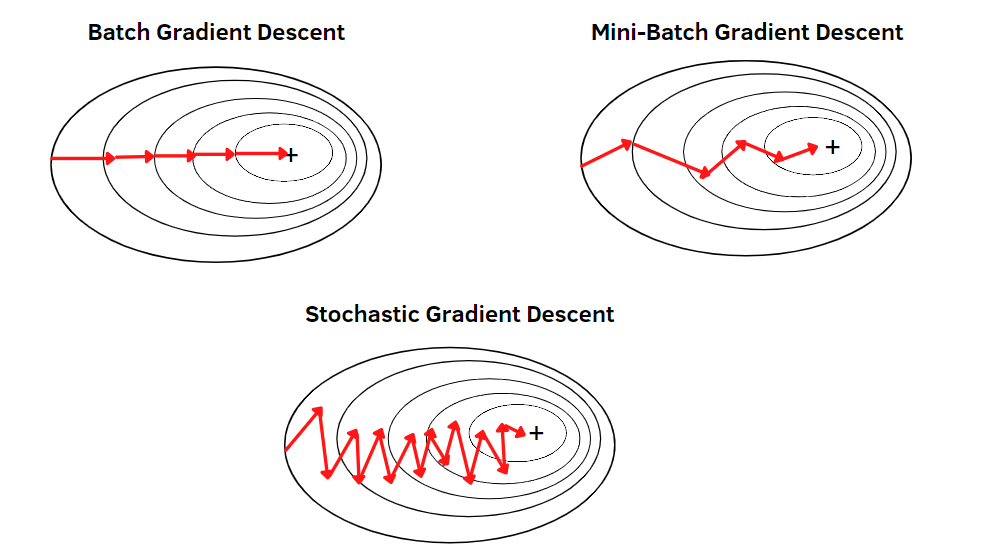

In [ ]:
#Create and load mini batches (Usual method)
'''
We use DataSet and DataLoder Library for this

'''
class CreditCardFraudDataSet(Dataset):#inheritance
  def __init__(self,x,y):
    self.x=x
    self.y=y

  def __getitem__(self, index):
    return self.x[index],self.y[index] #ex: let's put index as 5 then we return 5th x value and 5th y value (return x and y value for given index)

  def __len__(self):
    return len(self.y)


In [ ]:
#creating actual dataset from the class
dataset = CreditCardFraudDataSet(x_train,y_train)
len(dataset)

284800

In [ ]:
#Example scenario
dataset.__getitem__(5)

(tensor([-1.9965, -0.2175,  0.5817,  0.7526, -0.1188,  0.3050, -0.0223,  0.3849,
          0.2180, -0.5176, -0.3411,  1.3140,  0.3602, -0.3598, -0.1430,  0.5655,
          0.4585, -0.0684,  0.0819, -0.0408,  0.1102, -0.2835, -0.7714, -0.0423,
         -0.6133, -0.4466,  0.2196,  0.6289,  0.2456, -0.3386],
        dtype=torch.float64),
 tensor([0]))

In [ ]:
#Iterable data component for training (mini batches)
trainloder=DataLoader(dataset=dataset,batch_size=config.batch_size,shuffle=True)

In [ ]:
#Demonstrate the data iteration
for (x_batch,y_batch) in trainloder:
  print(f"X shape:{x_batch.shape}")
  print(f"Y shape:{y_batch.shape}")
  break

X shape:torch.Size([32, 30])
Y shape:torch.Size([32, 1])


# **Define Neural Network Architecture**

In [ ]:
#Neural network class
class Perceptron(nn.Module):
  def __init__(self,input_features):
    # inherit all the features from parent class
    super(Perceptron,self).__init__()
    self.fc1 = nn.Linear(input_features, 16)
    self.fc2 = nn.Linear(16, 8)
    self.fc3 = nn.Linear(8, 4)
    self.fc4 = nn.Linear(4, 1)
    self.tanh = nn.Tanh()       #for hidden layer
    self.sigmoid = nn.Sigmoid() #for output layer

  # method to build the network flow
  def forward (self, x ):
    out = self.fc1(x)     #output of fully connected layer 1
    out = self.tanh(out)  #output of fully connected layer 1 goes with tanh function
    out = self.fc2(out)   #output of fully connected layer 2
    out = self.tanh(out)  #output of fully connected layer 2 goes with tanh function
    out = self.fc3(out)   #output of fully connected layer 3
    out = self.tanh(out)  #output of fully connected layer 3 goes with tanh function
    out = self.fc4(out)   #output of fully connected layer 4
    out = self.sigmoid(out) #for output layer

    return out


# **Training Process**

In [ ]:
# Initiate the netwrok and the components

input_features = 30

perceptron = Perceptron(input_features)
loss_function = torch.nn.BCELoss(reduction = 'mean')
optimizer = torch.optim.SGD(perceptron.parameters(),lr=config.lr, momentum =0.8)


In [ ]:
# Strat training the training process

for epoch in range (config.epochs):
  #inside a single epoch
  for (x_train,y_train) in trainloder:
    # inside a single mini batch

    #network except everything in float
    x_train=x_train.float()
    y_train=y_train.float()

    # Forward propagation
    outputs = perceptron(x_train)

    #compare with actual output and calculate the loss
    loss = loss_function(outputs,y_train)

    #clearing the gradient
    optimizer.zero_grad()

    #backpropagation
    loss.backward()

    #update the weights
    optimizer.step()

  outputs = (outputs > 0.5).float()

  accuracy =(outputs == y_train).float().mean()

  #printing the results into wand
  metrics ={
      "Epoch" :(epoch+1)/(config.epochs),
      "Loss": loss,
      "Accuracy":accuracy
  }

  wandb.log(metrics)

  print(f"Epoch: {(epoch+1)}/{(config.epochs)}, Loss:{loss}, Accuracy: {accuracy}")

wandb.finish()

Epoch: 1/50, Loss:0.0005707907839678228, Accuracy: 1.0
Epoch: 2/50, Loss:0.000359410943929106, Accuracy: 1.0
Epoch: 3/50, Loss:0.00027756369672715664, Accuracy: 1.0
Epoch: 4/50, Loss:0.00023659318685531616, Accuracy: 1.0
Epoch: 5/50, Loss:0.00018145347712561488, Accuracy: 1.0
Epoch: 6/50, Loss:0.00030402757693082094, Accuracy: 1.0
Epoch: 7/50, Loss:0.00024238390324171633, Accuracy: 1.0
Epoch: 8/50, Loss:0.00017308961832895875, Accuracy: 1.0
Epoch: 9/50, Loss:0.00017750263214111328, Accuracy: 1.0
Epoch: 10/50, Loss:0.00019348677597008646, Accuracy: 1.0
Epoch: 11/50, Loss:0.00017507885058876127, Accuracy: 1.0
Epoch: 12/50, Loss:0.0002187142672482878, Accuracy: 1.0
Epoch: 13/50, Loss:9.971884719561785e-05, Accuracy: 1.0
Epoch: 14/50, Loss:0.002408536383882165, Accuracy: 1.0
Epoch: 15/50, Loss:0.00025786369224078953, Accuracy: 1.0
Epoch: 16/50, Loss:0.00011157109111081809, Accuracy: 1.0
Epoch: 17/50, Loss:0.00020462840620893985, Accuracy: 1.0
Epoch: 18/50, Loss:0.001732397242449224, Accura

Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,▂▁▁▁▁▁▁▁▁▁▁▄▁▁▃▆▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
Accuracy,1.0
Epoch,1.0
Loss,0.00023
